In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart-reduced/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = ['price', 'shipweight', 'length', 'width', 'height'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        dropout=0.5,
                        batch_norm=True,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        shared_lstm=True)

Number of inputs to dense layer: 177


# Train model 

In [83]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=4096,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 158s 2ms/step - loss: 0.0044 - acc: 0.9992 - val_loss: 0.0188 - val_acc: 0.9983


# Learning curves

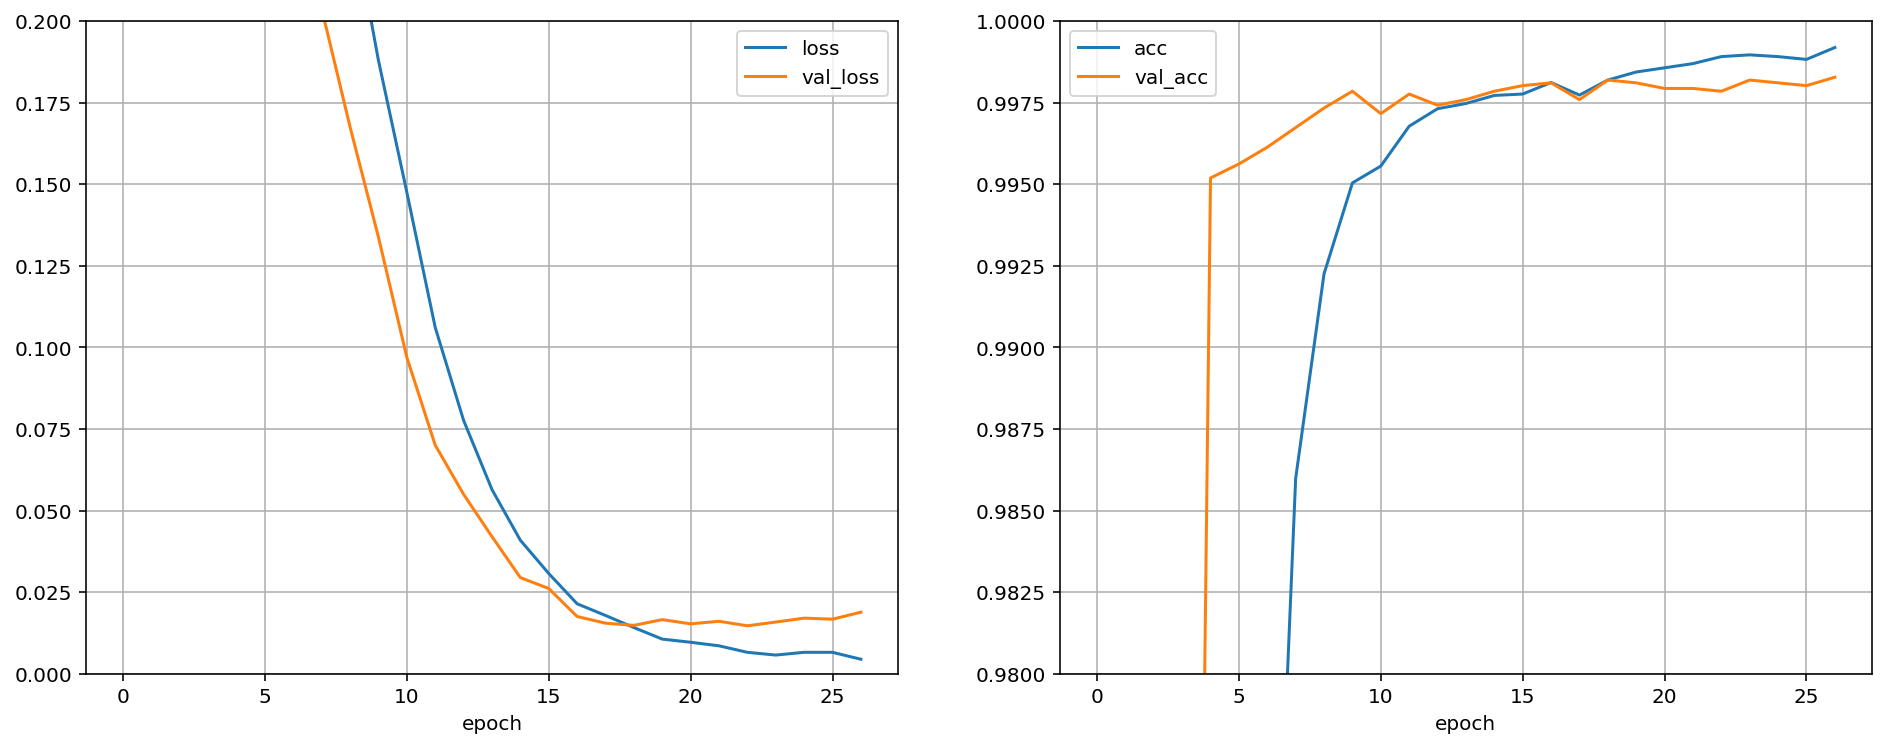

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set(ylim = (0, 0.2))
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set(ylim = (0.98, 1))

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [73]:
y_val_pred = model.predict(X_val, batch_size=4096)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11529
          1       0.90      0.94      0.92       127

avg / total       1.00      1.00      1.00     11656

[[11516    13]
 [    8   119]]


In [74]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & (y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(10)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
3714,21375,royal,envelopes mailers shipping supplies,royal ds3 postal rate scale 17012y,29.49,pound weight capacity ounce increments pull out storage drawer digital read out tare and hold feature,nan,digital postal scale,0.0,7.6,...,stationery office machinery,royal ds3 postal rate scale,24.54,pounds weight capacity kilograms resolution ounce gram increments storage drawer convenient storage for stamps paper clips,nan,pounds weight capacity kilograms resolution ounce gram increments storage drawer convenient storage for stamps paper clips digital tare feature hold feature displays weight in pounds ounces or metric postal rate chart included us postal service and canada post,1.05,8.70,7.00,2.70
9419,10274,,video cables,bell hd7102 high speed hdmi cables,90.00,hdmi hd7100 series high speed digital cables 3d ready 24k gold plating provides optimum data gbps truspeed transfer rate 1080p our hdmi cables have been independently tested to the speed rating stated for it lifejacket is designed for high performance both outside and inside your lifejacket cable covering provides excellent flexibility durability and meets ul cl3 csa ft4 listed for oxygen free copper this provides excellent conductivity and corrosion the copper wire within each cable is precision terminated at the connectors to provide the optimum for more furniture wall mounts cables and accessories options by bell go to,nan,bell hdmi7100 series hd7102 feet meter high speed hdmi cables with 180 degree swivel head ethernet and 3d engineered for superior performance advanced technologies including 3d ready ethernet capability and gigabit per second transfer rate that exceeds today standards making these the last cables you ll need for very long,0.0,11.0,...,tv accessories,bell hdmi cable with ethernet,69.99,truspeed transfer rate lifejacket ul listed for installation swivel connector head,your tv is only as good as the signal it bell hdmi cables ensure that all of the audio and video data available reaches your system to bring your experience to advanced technologies and truspeed tested gigabit per second transfer rate depending on length exceed today standards making these the last cables you ll need for very long,bell hdmi cable with ethernet truspeed transfer rate lifejacket ul listed for installation hdmi ethernet channel audio return channel 1080p hd video swivel connector head,0.50,80.00,0.50,0.50
5430,11705,plantronics,electronics,plantronics headset to usb adapter da40,49.95,voip capability when paired with any plantronics professional headset specifically designed for enterprise office communication or employees with both desk phone and softphone alternative to headset systems,nan,plantronics da series adapter da40 cable adapters,0.0,7.0,...,electronics general,plantronics adapter,27.98,voip capability when paired with any plantronics professional headset,nan,voip capability when paired with any plantronics professional headset specifically designed for enterprise office communication or employees with both desk phone and softphone alternative to headset systems,0.33,6.75,5.50,2.00
4581,8359,atrend,office products,box series 10 enclosure for dodge ram quad cab 2002,94.53,fits 2002 amp up dodge ram quad mdf speaker completely carpeted enclosure with rounded custom built for,nan,fits 2002 amp up dodge ram quad cabmdf speaker bafflescompletely carpeted enclosure with rounded edgescustom built for applicationscrewed down terminal cupscompletely glued amp braced10 single sealed fits crew cabsupc 636644998160shipping dimensions shipping weight,0.0,0.0,...,car stereos,box series 10 enclosure,60.88,for dodge ram quad cab 2002 and up mdf construction custom built for under seat application,the box series 10 enclosure fits dodge ram quad cabs 2002 and it is custom built so that you can put it under your se

# Save model and histories 

In [75]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-base-2-num.csv', index=False)
model.save_weights('../data/models/amazon-walmart-base-2-num')

# Test model 

In [76]:
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11541
          1       0.91      0.88      0.89       114

avg / total       1.00      1.00      1.00     11655

[[11531    10]
 [   14   100]]
